# Project Milestone 2 : _Donald Trump’s Influence on the Covid Infodemic: An Assessment of a Leader’s Impact on (Mis)information Spread_

---
## Context


Donald Trump’s many tweets during the Covid pandemic spread like wildfire, probably making him one of the most
influential figures during the pandemic – but in the end, was he that influential? Will causal analyses of the effect of
Trump’s tweets on Wikipedia and Google Trends pageviews show that he was leading or following online trends? Our
goal is to study the impact an influential leader can have on information spread in a
crisis with a focus on fake news, as an overload of misleading or contradictory
statements (an infodemic, as [WHO](https://www.who.int/health-topics/infodemic#tab=tab_1) calls it) are known to have a detrimental impact on crisis
management. To provide a more comprehensive insight into Trump’s actual influence
on online information spread, we would then like to compare it with that of other
factors such as mobility restrictions or key milestones (e.g. first Covid death). Trump
the Trend Maker or Trump the Follower, that is the question!


## Imports :

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,8)})
from datetime import datetime, timedelta
import re
import json
import spacy
import string
import wordcloud 
from wordcloud import WordCloud
from causalimpact import CausalImpact

# Local Modules
from wiki_pageviews_covid.analyses.helpers.load import load_interventions, load_aggregated, load_topics, load_pca
from wiki_pageviews_covid.analyses.helpers.vars import codes, helper_langs, interventions_helper, int_c, int_ls
from wiki_pageviews_covid.analyses.helpers.plot import set_size, plot_dates, plot_intervention, plot_cumm_diff
from wiki_pageviews_covid.analyses.helpers.pca import get_attention_shift_ts 
import matplotlib as mpl
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D

from wiki_gtrend_visualization import load_wikipedia_df, load_gtrend_df
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn import metrics
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


---
## Part 1: Causal Impact Analysis of Trump's Tweets on Wikipedia Pageviews

### A) We start by preparing and familiarizing with our data

Our datasets :
- Covid dataset from ada class
- Donald Trump's tweet between 2019 and
  2021: [Kaggle](https://www.kaggle.com/datasets/codebreaker619/donald-trump-tweets-dataset)
- List of known fake news and their Google trends'
  reference : [GitHub](https://github.com/epfl-dlab/fact-checkers-fact-check/blob/main/data/kg_ids.json)
- Data extracted from Google Trends and Wikipedia (will be done after)

Let's present Donald Trump's tweets dataset 

In [2]:
# build a personalyze data parser
custom_date = lambda x: datetime.strptime(x.split()[0], '%Y-%m-%d')
df = pd.read_csv('tweets.csv', parse_dates=['date'], date_parser=custom_date)

C:\Users\User\AppData\Local\Temp\ipykernel_13828\286679866.py:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv('tweets.csv', parse_dates=['date'], date_parser=custom_date)


This dataset contains all his tweets and retweets from 2009 to January, 8 2021 (one day before he was banned from Twitter) :

In [3]:
df.sample(5)

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
39365,795479521520717825,Thank you Pennsylvania- I am forever grateful ...,f,f,Twitter for iPhone,40512,15131,2016-11-07,f
2206,1323470806240927745,Biden has vowed to ABOLISH the American oil an...,f,f,Twitter for iPhone,69452,14429,2020-11-03,f
6658,1277954189008744448,We are tracking down the two Anarchists who th...,f,f,Twitter for iPhone,260569,56961,2020-06-30,f
15893,247784012322594816,Gas prices have doubled under Obama. Over $5/g...,f,f,Twitter Web Client,69,496,2012-09-17,f
1141,1327747263188316160,RT @realDonaldTrump: https://t.co/RV5obxT9aG,t,f,Twitter for iPhone,0,46413,2020-11-14,f


There is no empty row in the dataset :

In [4]:
print('Number of rows with Nan value is', len(df)-(~df.isna()).prod(axis= 1).sum())

Number of rows with Nan value is 0


Let's focus on the Covid period:

In [5]:
df_covid = df[df['date'] >= '2019-12-01']
df_covid.sort_values(by='date')
df_covid.head(5)

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03,f
2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,2020-01-17,f
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12,f
4,1218159531554897920,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,2020-01-17,f
5,1217962723234983937,RT @WhiteHouse: President @realDonaldTrump ann...,t,f,Twitter for iPhone,0,25048,2020-01-17,f


Let's check whether Donald Trump Tweeted every day :

In [6]:
time_span = pd.date_range(start = min(df_covid['date']), end = max(df_covid['date']), freq='D')

data=df_covid.copy()
data = pd.merge(data, pd.DataFrame(time_span, columns=['date']), on='date', how='right')

print('Number of days where he did not tweet ' , data['id'].isna().sum())

Number of days where he did not tweet  1


Since there is only one day where he didn't tweet, we can drop this day from our dataset, it won't affect our analysis.

In [7]:
data.dropna(inplace=True)

data['per_day_tweets']= data.groupby('date')['date'].transform('count')
data['per_day_retweets']= data.groupby('date')['retweets'].transform('sum')
data['per_day_likes']= data.groupby('date')['favorites'].transform('sum')

We can have a look at the temporal evolutions of Trump's tweets :

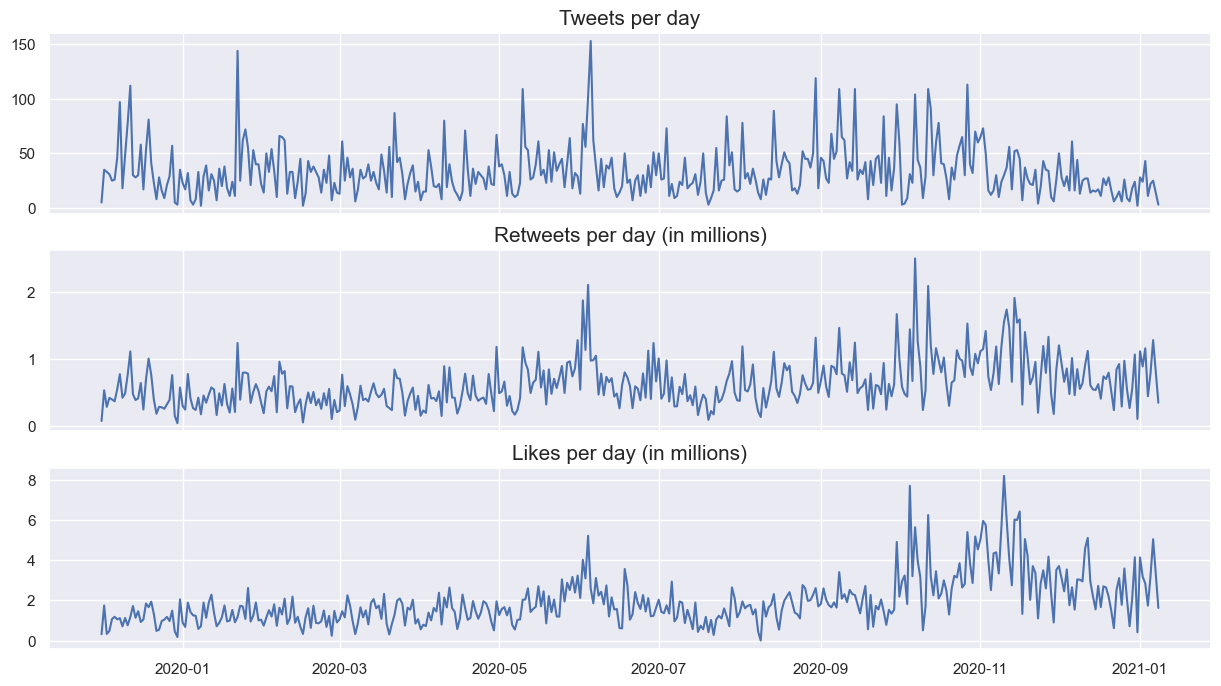

In [8]:
fig, axes = plt.subplots(nrows = 3, ncols = 1, sharex=True, sharey=False)

axes[0].plot(data['date'], data['per_day_tweets'])
axes[0].set_title('Tweets per day', size=15)
axes[1].plot(data['date'], data['per_day_retweets']/10**6)
axes[1].set_title('Retweets per day (in millions)', size=15)
axes[2].plot(data['date'], data['per_day_likes']/10**6)
axes[2].set_title('Likes per day (in millions)', size=15)

plt.show()

Let's have an idea of the type of tweets we have :

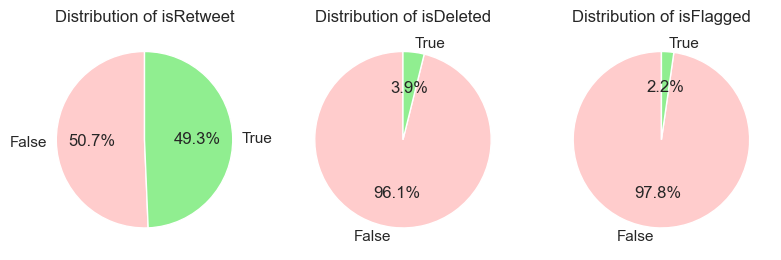

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(8, 12))

variables = ['isRetweet', 'isDeleted', 'isFlagged']
colors = ['#FFCCCC', 'lightgreen']

for i, var in enumerate(variables):
    ax = axes[i]
    ax.pie(data[var].value_counts(), labels=['False', 'True'], autopct='%1.1f%%', startangle=90, colors=colors)
    ax.set_title(f'Distribution of {var}')

plt.tight_layout()
plt.show()


There are very few deleted tweets, though this can be an indication of misinformation spreaded by Trump.

Use spacy to get rid of stop words in the tweets. Stop words are all that words such as and, or, that, etc. that are not relevant for a tweet but are used very often.

In [10]:
#Before running following command install dictionary with:
#python -m spacy download en_core_web_sm

#download a english dictionary to make anlysis
nlp = spacy.load('en_core_web_sm')
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
print('Number of stop words: %d' % len(spacy_stopwords))

Number of stop words: 326


In [11]:
#all tweets in one string
result_text = ' '.join(data['text'])

def remove_stopwords(chunk):
    return ' '.join([token.text for token in chunk if (not token.is_stop)])

#the text we have is too big to process it at once, so we split it into chunks
chunk_size = 100000
chunks = [result_text[i:i+chunk_size] for i in range(0, len(result_text), chunk_size)]
processed_chunks = [nlp(chunk) for chunk in chunks]
processed_chunks_no_stopwords = [remove_stopwords(chunk) for chunk in processed_chunks]

#manually clean text from links, punctuation, etc.
clean = ' '.join(processed_chunks_no_stopwords)
clean= re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '',clean)#remove links
clean= clean.translate(str.maketrans('', '', string.punctuation))#remove punctuation
clean = clean.replace('amp', '')
clean = clean.replace('RT', '')
clean = clean.replace('realDonaldTrump', '')

Let's have a look at the most used words in Trump's tweets :

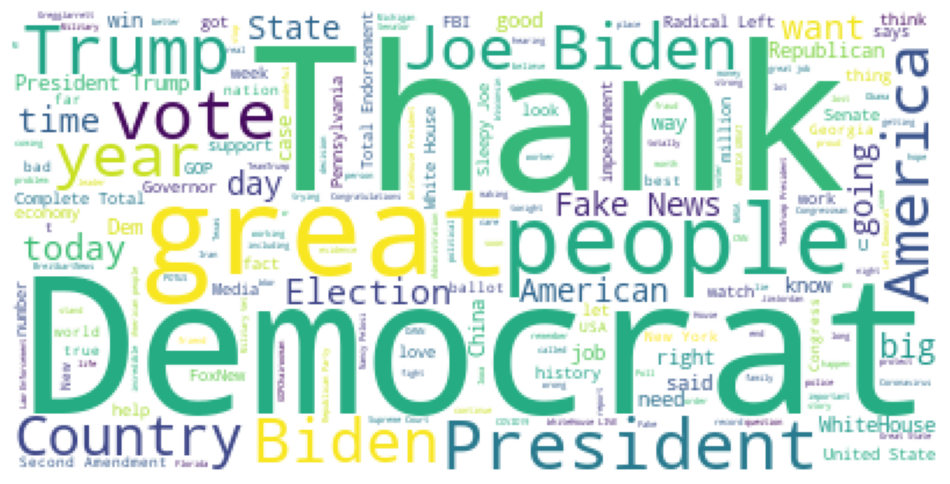

In [12]:
wordcloud = WordCloud(background_color="white").generate(clean)

plt.figure(figsize = (12, 12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

As we can see, there are not that much related to covid. Though one can already spot some of his favorite topics.

Let's focus our analysis on Covid-related tweets

In [13]:
#create a list of words related to covid
list_of_words = ['Covid19' ,'virus', 'vaccine', 'Flu', 'Covid', 'lockdown', 'pandemic', 'coronavirus', 'Coronavirus', 'Corona', 'corona', 'COVID19', 'COVID', 'covid', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantined', 'Quarantined', 'quarentined', 'Quarentined', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines']
data['covid_related'] = data['text'].apply(lambda x: True if any(word in x for word in list_of_words) else False)

data['covid_related'].value_counts()

covid_related
False    12874
True       644
Name: count, dtype: int64

In [14]:
#data where covid_related is true
data_covid_rel = data[data['covid_related']==1]

Following the same process, we can have a look at the most used words in Trump's Covid related tweets :

In [15]:
#all tweets in one string
result_text = ' '.join(data_covid_rel['text'])

def remove_stopwords(chunk):
    return ' '.join([token.text for token in chunk if (not token.is_stop)])

#the text we have is too big to process it at once, so we split it into chunks
chunk_size = 100000
chunks = [result_text[i:i+chunk_size] for i in range(0, len(result_text), chunk_size)]
processed_chunks = [nlp(chunk) for chunk in chunks]
processed_chunks_no_stopwords = [remove_stopwords(chunk) for chunk in processed_chunks]

#manually clean text from links, punctuation, etc.
clean = ' '.join(processed_chunks_no_stopwords)
clean= re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '',clean)#remove links
clean= clean.translate(str.maketrans('', '', string.punctuation))#remove punctuation
clean = clean.replace('amp', '')
clean = clean.replace('RT', '')
clean = clean.replace('realDonaldTrump', '')

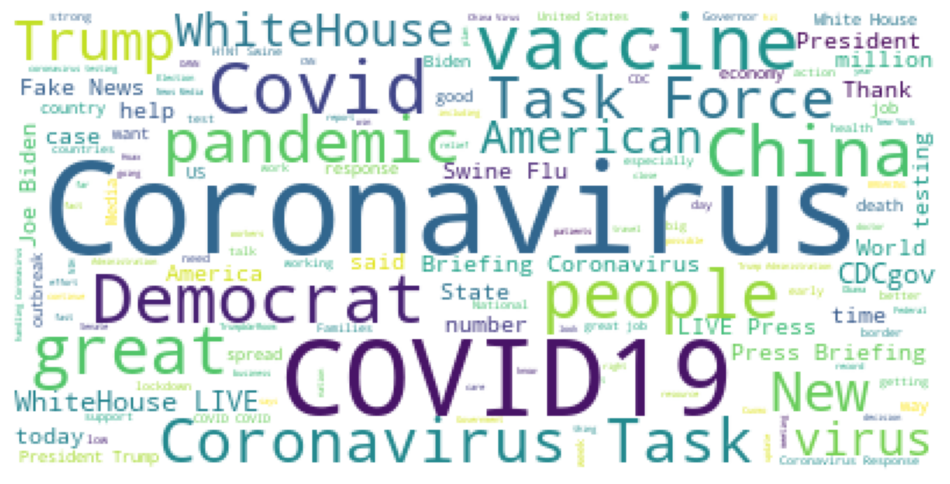

In [16]:
wordcloud = WordCloud(background_color="white").generate(clean)

plt.figure(figsize = (12, 12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

This image shows a more spreaded distribution of words. Though, one can spot the importance of china, vaccine or even swine flu in his tweets. Lots of words were also related to actions such as Task Force, Live Press or Briefing.

Let's find the moment when Trump tweeted the most about Covid:

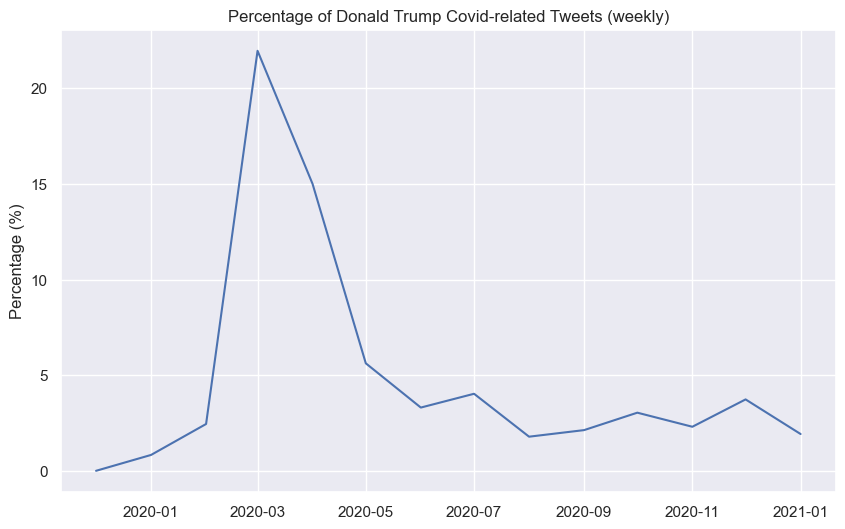

In [17]:
data['month_date'] = data.date.apply(lambda x: x.month)
data['year_date'] = data.date.apply(lambda x: x.year)
frequency_plot = data.groupby(by=['month_date', 'year_date']).apply(lambda x: x.covid_related.sum() / x.covid_related.count()).reset_index()
frequency_plot['date'] = [datetime(year=y, month=x, day=1) for x,y in zip(frequency_plot.month_date.values, frequency_plot.year_date.values)]
frequency_plot = frequency_plot.sort_values(by='date')

#plot the percentage of covid related tweets
plt.figure(figsize=(10, 6)) 
plt.ylabel('Percentage (%)')
plt.plot(frequency_plot.date, frequency_plot.iloc[:,2] * 100)
plt.title('Percentage of Donald Trump Covid-related Tweets (weekly)')
plt.show()

As we can see the highest density of covid related tweets is in March 2020, which is the beginning of the pandemic in the US. In March the percentage peaked at 20%. We can also see that the density of covid related tweets is decreasing over time.

Now let's discover if among the most retweeted and the most liked tweets there are some that are related to covid:

In [18]:
data['decile_retweeted'] = pd.qcut(data['retweets'], 10, labels=False, duplicates='drop')
data['decile_favorites'] = pd.qcut(data['favorites'], 10, labels=False, duplicates='drop')

Not all tweets have the same impact on public opinion, hence we want to see in which period covid related tweets were among the most relevant, to adress importance we use retweet as a proxy.

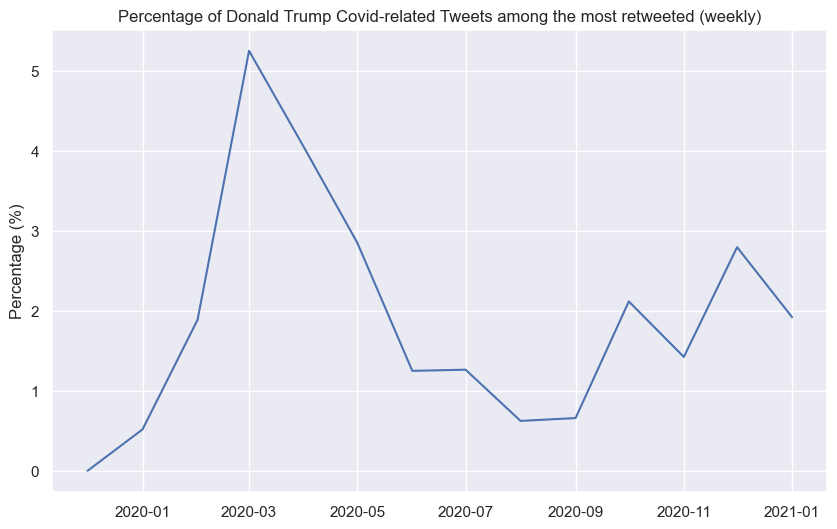

In [19]:
frequency_plot = data.groupby(by=['month_date', 'year_date']).apply(lambda x: 
                                                                    ((x.covid_related)*((x.decile_retweeted==9)|(x.decile_retweeted==8)|(x.decile_retweeted==7)|
                                                                                        (x.decile_retweeted==6)|(x.decile_retweeted==5))).sum() 
                                                                                        / x.covid_related.count()).reset_index()
frequency_plot['date'] = [datetime(year=y, month=x, day=1) for x,y in zip(frequency_plot.month_date.values, frequency_plot.year_date.values)]
frequency_plot = frequency_plot.sort_values(by='date')

plt.figure(figsize=(10, 6)) 
plt.ylabel('Percentage (%)')
plt.plot(frequency_plot.date, frequency_plot.iloc[:,2] * 100)
plt.title('Percentage of Donald Trump Covid-related Tweets among the most retweeted (weekly)')
plt.show()

**As we can see the moment were we had the highest share of covid related tweets (March 2020) is also the moment we had also the highest number of tweets related to covid.**

## Focus on sentiment analysis

VADER is a lexicon and rule-based sentiment analysis tool, specific in a Social-media context. 

In [20]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Define a funcrion to get and plot the aggregate sentiment of the tweets in the dataset.

In [21]:
def get_sentiment_(df):
  #get the scores of each tweet
  df['scores'] = df['text'].apply(lambda Description: sid.polarity_scores(Description)) 

  #calculate the sentiment score which is a combination of positive, negative and neutral(not mean)
  df['compound']  = df['scores'].apply(lambda score_dict: score_dict['compound'])
  df['sentiment_type']=''
  df.loc[df.compound>0,'sentiment_type']='POSITIVE'
  df.loc[df.compound==0,'sentiment_type']='NEUTRAL'
  df.loc[df.compound<0,'sentiment_type']='NEGATIVE'

  #aggrergate by day month and year # we want to inspect aggregate value per day, week and month
  df['month_date'] = df.date.apply(lambda x: x.month)
  df['year_date'] = df.date.apply(lambda x: x.year)
  df['daily'] = df.date.apply(lambda x: x.day)
  df['week'] = df['date'].dt.isocalendar().week

  # take the mean of the compound value for each day, week and month
  #daily
  freq_d = df.groupby(by=['year_date','month_date','daily']).apply(lambda x: x.compound.mean())
  freq_d = freq_d.reset_index()
  freq_d = freq_d.rename(columns={0: 'compound'})
  
  #weekly
  freq_w = df.groupby(['year_date','month_date','week']).apply(lambda x: x.compound.mean())
  freq_w = freq_w.reset_index()
  freq_w = freq_w.rename(columns={0: 'compound'})

  #monthly
  freq_m = df.groupby(by=['year_date','month_date']).apply(lambda x: x.compound.mean())
  freq_m = freq_m.reset_index()
  freq_m = freq_m.rename(columns={0: 'compound'})

  # drop week first last two weeks unresonable values
  freq_w = freq_w.iloc[1:-1]

  #monthly
  freq_m.year_date = freq_m.year_date.astype(str)
  freq_m.month_date = freq_m.month_date.astype(str)
  freq_m['date'] = freq_m.apply(lambda x: datetime.strptime(str(x.year_date) + '-' + str(x.month_date), '%Y-%m'), axis=1)

  #manipulation to get nice plot
  #daily
  freq_d.year_date = freq_d.year_date.astype(str)
  freq_d.month_date = freq_d.month_date.astype(str)
  freq_d.daily = freq_d.daily.astype(str)
  freq_d['date'] = freq_d.apply(lambda x: datetime.strptime(str(x.year_date) + '-' + str(x.month_date) + '-' + str(x.daily), '%Y-%m-%d'), axis=1)

  #weekly
  freq_w.year_date = freq_w.year_date.astype(str)
  freq_w.month_date = freq_w.month_date.astype(str)
  freq_w.week = freq_w.week.astype(str)
  freq_w['date'] = pd.to_datetime(freq_w['year_date'].astype(str) + freq_w['week'].astype(str) + '-1', format='%G%V-%u')

  plt.figure(figsize=(10, 6))

  # Plotting freq_m
  plt.plot(freq_m['date'], freq_m['compound'], label='Monthly' , linestyle='-')

  # Plotting freq_d
  plt.plot(freq_d['date'], freq_d['compound'], label='Daily', linestyle='-')

  # Plotting freq_w
  plt.plot(freq_w['date'], freq_w['compound'], label='Weekly', linestyle='-')

  plt.xlabel('Date')
  plt.ylabel('Compound Value')
  plt.title('Compound Values Over Time')
  plt.legend()
  plt.xticks(rotation=45) 
  plt.grid(True)
  plt.tight_layout()
  plt.show()
  return df, freq_d

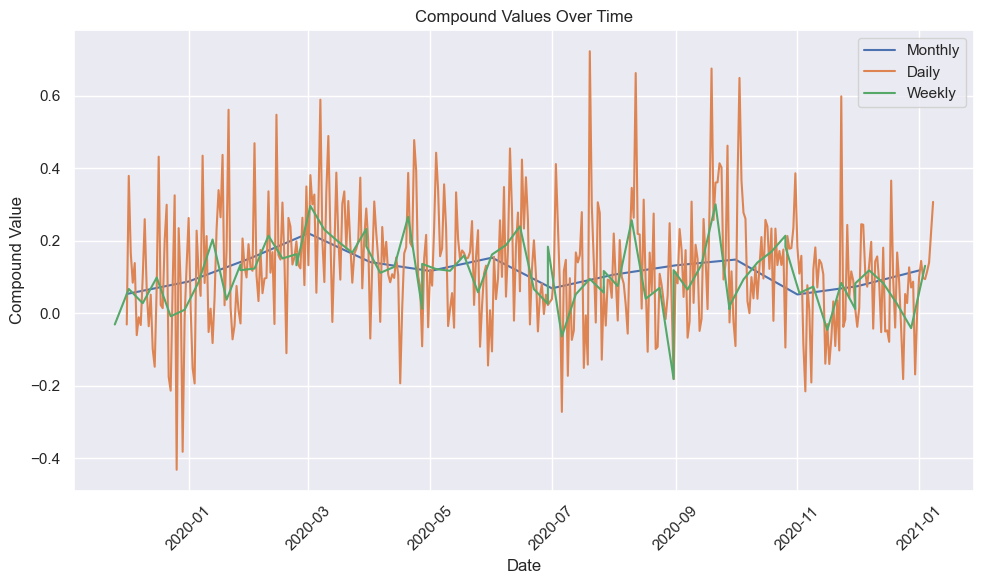

In [22]:
data_tot, freq_d = get_sentiment_(data)

The aggregate timeseries of the sentiment shows some interesting features:
- The sentiment in Trump's tweet is mainly positive: as soon as the aggregation becomes weekly the aggregate sentiment becomes negative in a extremly limited numer of weeks. Further dimnuishibg the granularity of the aggregation (monthly) the sentiment becomes always positive.
- No aggregate tweets have a sentiment score above 0.6 or under -0.4, however we can see, fixing as a threshold $\pm 0.4$ thate the 'positive spikes' are much more frequent than the 'negative spikes'.

There could be two reasons for this:
- The first one is that, as a politician, Trump is more likely to tweet about positive events than negative ones. Bringing up to surface and enphatizing positive events about himslef is a way to get consensus.
-The second one is that the VADER lexicon is not able to capture the sentiment of the tweets. Or at least the sarcastic ones. Even if Vader is specific for social media, the sarcasm detection is something pretty difficult to achieve, hence there could be some bias due to the high number of sarcastic tweets.

To clarify this doubts we can plot the sentiment about Joe Biden, we except to be negative, since he is the opponent of Trump.

In [23]:
# now look at Joe Biden tweets
#create a list of words related to Joe Biden
biden_words = ['Joe', 'Biden', 'Democrat', 'democrat', 'democratic', 'Democratic', 'president', 'President', 'VP', 'vice president', 'Vice President', 'Kamala', 'Harris', 'Kamala Harris', 'KamalaHarris', 'KamalaHarrisVP', 'KamalaHarrisVPPresident', 'KamalaHarrisV']
data['biden_related'] = data['text'].apply(lambda x: True if any(word in x for word in biden_words) else False)
#data where covid_related is true
data_biden_rel = data[data['biden_related']==1]

C:\Users\User\AppData\Local\Temp\ipykernel_13828\3441226468.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['scores'] = df['text'].apply(lambda Description: sid.polarity_scores(Description))
C:\Users\User\AppData\Local\Temp\ipykernel_13828\3441226468.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['compound']  = df['scores'].apply(lambda score_dict: score_dict['compound'])
C:\Users\User\AppData\Local\Temp\ipykernel_13828\3441226468.py:7: SettingWithCopyWarning: 
A value is trying to be set on 

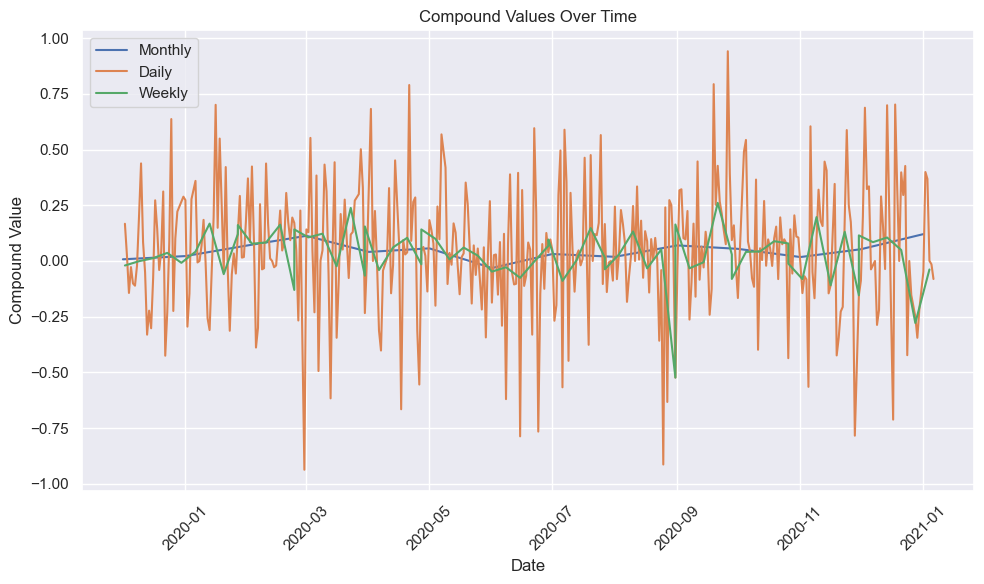

In [24]:
data_biden, freq_d_biden = get_sentiment_(data_biden_rel)

When examining the data concerning Biden, the sentiment appears to hover closer to neutrality (around 0), particularly when aggregated on a monthly basis, where it consistently remains slightly above 0. The spikes in sentiment are more evenly distributed, suggesting a balanced spectrum of opinions. However, it's crucial to approach these results with caution as sentiment analysis tools like VADER may not entirely capture the nuances of sarcasm evident in some of Trump's tweets.

## Covid Related Tweets

C:\Users\User\AppData\Local\Temp\ipykernel_13828\3441226468.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['scores'] = df['text'].apply(lambda Description: sid.polarity_scores(Description))
C:\Users\User\AppData\Local\Temp\ipykernel_13828\3441226468.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['compound']  = df['scores'].apply(lambda score_dict: score_dict['compound'])
C:\Users\User\AppData\Local\Temp\ipykernel_13828\3441226468.py:7: SettingWithCopyWarning: 
A value is trying to be set on 

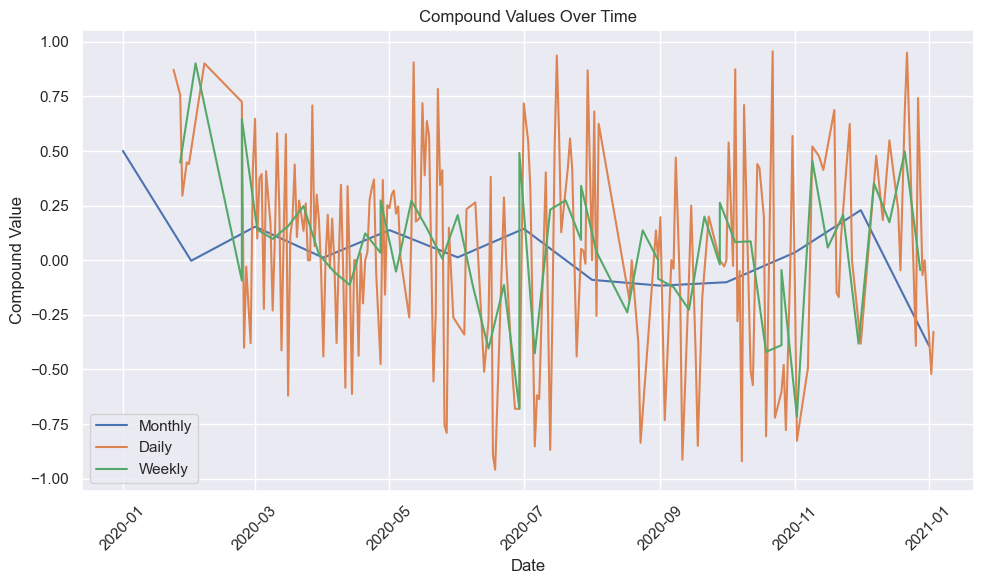

In [25]:
#data where covid_related is true
data_covid_rel = data[data['covid_related']==1]
drr, freq_dc = get_sentiment_(data_covid_rel)

The sentiment is way more volatile than the two cases considered above. This is due to the fact we have less data about covid, however, in contrast to the previous trade, it seems there is a slightly negative trend in the sentiment. This could be due to the fact that the pandemic is still ongoing and the situation is not improving. It is also probable that sarcasm related to Covid-19 is less frequent than the one related to politics. 

We focus on the period were Covid-19 was spreading in the US. From our data-visualization we already assess that march-april was the period with the highest number of tweets related to Covid in Trump's tweet dataset.

In [26]:
#subset old one
start_date = '2020-03-19'
end_date = '2020-04-18'
freq_d_subc = freq_dc[(freq_dc['date'] >= start_date) & (freq_dc['date'] <= end_date)]

## Predictive analysis

We want to see if we find predictors for Trump's tweets sentiment.
From kaggle datset 20 March - 18 April, data from kaggle sentiment among people in US.<p>
The Idea is to see if sentiment in population has predictive power on Trump's tweets sentiment.

In [27]:
#import datasets
combined_df = pd.DataFrame()
file_path = 'data'
files = [file for file in os.listdir(file_path)]
# Create a list of DataFrames by reading each CSV file
dataframes = [pd.read_csv(file_path+'/'+file) for file in files]

# Concatenate the list of DataFrames into a single DataFrame
combined_df = pd.concat(dataframes, ignore_index=True)
combined_df= combined_df.dropna(subset=['text'])

Create column date combining year, month and day

In [28]:
combined_df.user_location.value_counts()
US_df = combined_df[combined_df['user_location']=='United States']
US_df['date']=pd.to_datetime(US_df['created_at'], format='%a %b %d %H:%M:%S +0000 %Y', errors='coerce').dt.floor('D') 

C:\Users\User\AppData\Local\Temp\ipykernel_13828\1456329594.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  US_df['date']=pd.to_datetime(US_df['created_at'], format='%a %b %d %H:%M:%S +0000 %Y', errors='coerce').dt.floor('D')


In [29]:
US_df.loc[:,'scores'] = US_df['text'].apply(lambda review: sid.polarity_scores(review))

US_df['compound']  = US_df['scores'].apply(lambda score_dict: score_dict['compound'])
#consider the one different from 0
US_df=US_df[US_df['compound']!=0]
#aggregate vale per date
US_df_agg = US_df['compound'].groupby(US_df['date']).mean().reset_index()

C:\Users\User\AppData\Local\Temp\ipykernel_13828\4156942176.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  US_df.loc[:,'scores'] = US_df['text'].apply(lambda review: sid.polarity_scores(review))
C:\Users\User\AppData\Local\Temp\ipykernel_13828\4156942176.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  US_df['compound']  = US_df['scores'].apply(lambda score_dict: score_dict['compound'])


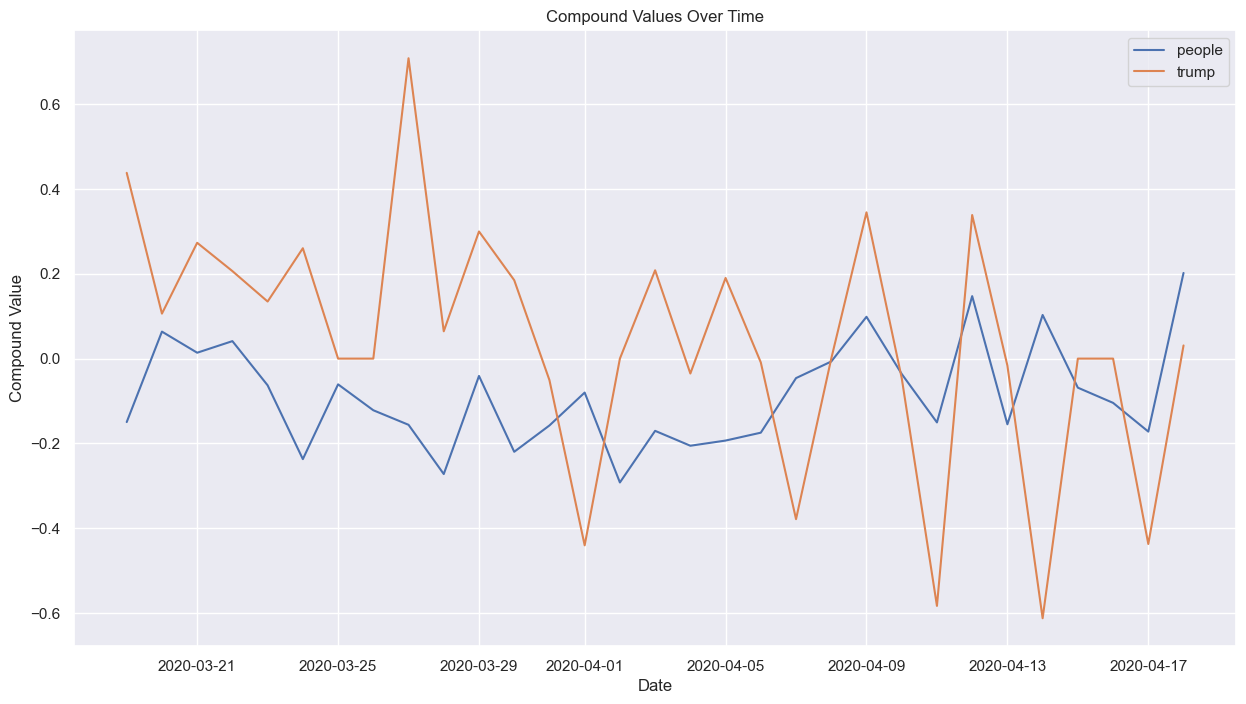

In [30]:
plt.plot(US_df_agg['date'], US_df_agg['compound'], label='people', linestyle='-')
plt.plot(freq_d_subc['date'], freq_d_subc['compound'], label='trump', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Compound Value')
plt.title('Compound Values Over Time')
plt.legend()
plt.show()

merge dataframes with people sentiment and trump sentiment

In [31]:
merged_dfc = pd.merge(US_df_agg, freq_d_subc, on='date', how='inner')
merged_dfc.rename(columns={'compound_x': 'people', 'compound_y': 'Trump'}, inplace=True)

Now we have a dataset with only tweets about covid, let's see if there is a correlation between the sentiment of the people about covid and the sentiment of Trump's tweets(only about covid)

In [32]:
merged_dfc['Trump_sent']= merged_dfc['Trump'].apply(lambda x: 1 if x>0 else 0 )
merged_dfc['people_sent']= merged_dfc['people'].apply(lambda x: 1 if x>0 else 0)

In [33]:
mod_1 = smf.logit(formula='Trump_sent ~ people_sent ', data=merged_dfc)
res_1 = mod_1.fit()
print(res_1.summary())

Optimization terminated successfully.
         Current function value: 0.604785
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             Trump_sent   No. Observations:                   31
Model:                          Logit   Df Residuals:                       29
Method:                           MLE   Df Model:                            1
Date:                Mon, 18 Dec 2023   Pseudo R-squ.:                  0.1268
Time:                        18:01:55   Log-Likelihood:                -18.748
converged:                       True   LL-Null:                       -21.471
Covariance Type:            nonrobust   LLR p-value:                   0.01961
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.5108      0.422     -1.212      0.226      -1.337       0.316
people_sent     2.3026    

We see that the people sentiment variable has a positive correation with Trump's tweet sentiment. It is significative at 5% level, then we have predictive power. 

## Predictive analysis (2)

Let's consider a timeseries of new cases of covid in US and see if the variation of the new cases can be used to predict Trump's sentiment tweets the dataset reports the absolute number of new cases, we need to calculate the variation of new cases.

In [34]:
covid = pd.read_csv('timesco/time-series-19-covid-combined.csv')
covid.head()

cov_us = covid[covid['Country/Region']=='US']
sub_cov = cov_us[(cov_us['Date'] >= start_date) & (cov_us['Date'] <= end_date)]

FileNotFoundError: [Errno 2] No such file or directory: 'timesco/time-series-19-covid-combined.csv'

Add the columns with people and Trump sentiment

In [ ]:
sub_cov.loc[:,'trump_sent'] = merged_dfc['Trump_sent'].values
sub_cov.loc[:,'peopl_sent'] = merged_dfc['people_sent'].values
sub_cov.loc[:,'Trump']= merged_dfc['Trump'].values
sub_cov.loc[:,'people']= merged_dfc['people'].values

C:\Users\User\AppData\Local\Temp\ipykernel_3568\344740220.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_cov.loc[:,'trump_sent'] = merged_dfc['Trump_sent'].values
C:\Users\User\AppData\Local\Temp\ipykernel_3568\344740220.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_cov.loc[:,'peopl_sent'] = merged_dfc['people_sent'].values
C:\Users\User\AppData\Local\Temp\ipykernel_3568\344740220.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

variation of cases in new cases, in the dataframe we have absolute numbers

In [ ]:
logit_df = sub_cov.copy()
logit_df['increase_new_cases'] = logit_df['Confirmed'].shift(1)-logit_df['Confirmed']/logit_df['Confirmed']

In [ ]:
logit_df['Confirmed']= (logit_df['Confirmed']-logit_df['Confirmed'].mean())/logit_df['Confirmed'].std()
logit_df['Recovered']= (logit_df['Recovered']-logit_df['Recovered'].mean())/logit_df['Recovered'].std()
logit_df['Deaths']= (logit_df['Deaths']-logit_df['Deaths'].mean())/logit_df['Deaths'].std()
logit_df['increase_new_cases']= (logit_df['increase_new_cases']-logit_df['increase_new_cases'].mean())/logit_df['increase_new_cases'].std()

In [ ]:
mod5 = smf.logit(formula='trump_sent ~ increase_new_cases ', data=logit_df)
res5 = mod5.fit()
print(res5.summary())

Optimization terminated successfully.
         Current function value: 0.603617
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:             trump_sent   No. Observations:                   30
Model:                          Logit   Df Residuals:                       28
Method:                           MLE   Df Model:                            1
Date:                Fri, 15 Dec 2023   Pseudo R-squ.:                  0.1264
Time:                        10:56:51   Log-Likelihood:                -18.109
converged:                       True   LL-Null:                       -20.728
Covariance Type:            nonrobust   LLR p-value:                   0.02209
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.1785      0.404     -0.442      0.658      -0.969       0.612
incre

From the summary we can see that the variation of new cases has a negative correlation with Trump's sentiment tweets. It is significative at 5% level, then we have predictive power.
It is reasonable since we expect that if the number of new cases is increasing, Trump's sentiment is worsening.

## Predictive analysis combined

Let's combine the two models, let's see if the variables keep their predictive power, and how the model performs.

In [ ]:
mod6 = smf.logit(formula='trump_sent ~ peopl_sent + increase_new_cases', data=logit_df)
res6 = mod6.fit()
print(res6.summary())

Optimization terminated successfully.
         Current function value: 0.426899
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             trump_sent   No. Observations:                   30
Model:                          Logit   Df Residuals:                       27
Method:                           MLE   Df Model:                            2
Date:                Fri, 15 Dec 2023   Pseudo R-squ.:                  0.3821
Time:                        10:56:51   Log-Likelihood:                -12.807
converged:                       True   LL-Null:                       -20.728
Covariance Type:            nonrobust   LLR p-value:                 0.0003631
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.2070      0.679     -1.777      0.076      -2.538       0.124
peopl

All the results we got in the previous models are confirmed, the two variables have predictive power and the model performs well. Actually the p-values are ven lower than in the previous models, both variables are significative at 2.5% level.

It seems that both variables have predictive power, let's scale the increment in new cases between -1 and 1 with min max scaler, so that they are directly comparable to the sentiment variables.

In [ ]:
# Assuming 'data' is the variable you want to scale
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = logit_df['increase_new_cases'].values.reshape(-1, 1)  # If 'data' is a pandas Series
logit_df['scaled_new'] = scaler.fit_transform(scaled)


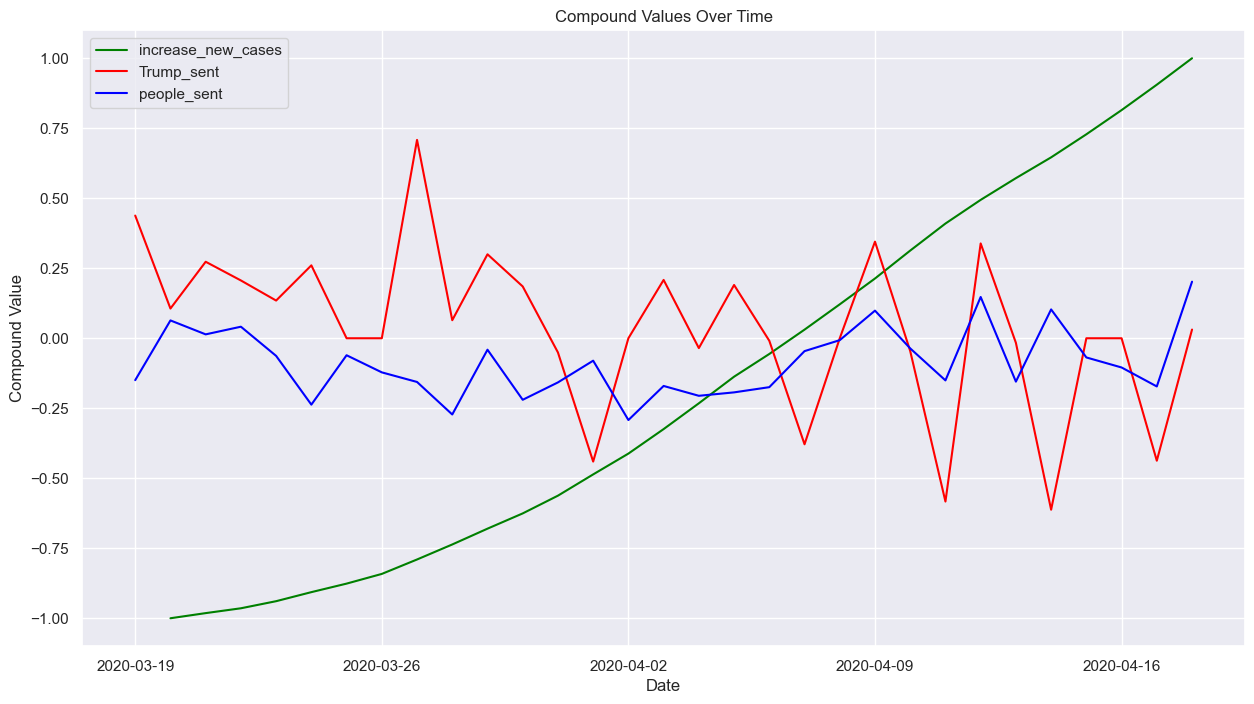

In [ ]:
# plots
plt.plot(logit_df['Date'], logit_df['scaled_new'], label='increase_new_cases', linestyle='-',color='green')
plt.plot(logit_df['Date'], logit_df['Trump'], label='Trump_sent', linestyle='-',color='red')
plt.plot(logit_df['Date'], logit_df['people'], label='people_sent', linestyle='-', color='blue')

n = 7 
plt.xticks(logit_df['Date'][::n])
plt.xlabel('Date')
plt.ylabel('Compound Value')
plt.title('Compound Values Over Time')
plt.legend()
plt.show()


The plot show that the two sentiment variables comove, at least is the period considered. It also noticible that the sentiments variables are negatively correlated with the variation of new cases, as expected. The trend of the variation of new cases is raising sharply, wherease the sentiment of the sentiment variables have a general negative trend.

In [ ]:
y_pred = res6.predict(logit_df[['peopl_sent', 'increase_new_cases']])
y_pred = [ 1 if y>=0.5 else 0 for y in y_pred]

Let's plot the confusion Matrix

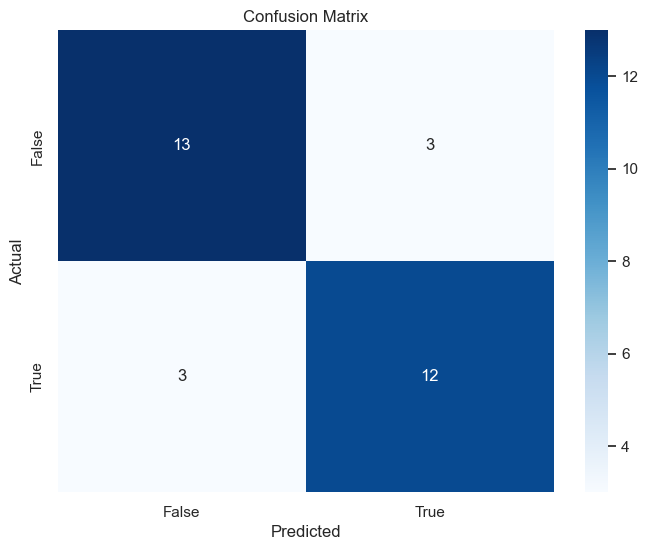

In [ ]:
confusion_matrix = metrics.confusion_matrix(logit_df.trump_sent, y_pred)
labels = ['False', 'True']  

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()


In [ ]:
precision = confusion_matrix[1][1]/(confusion_matrix[1][1]+confusion_matrix[0][1])
recall = confusion_matrix[1][1]/(confusion_matrix[1][1]+confusion_matrix[1][0])
f1 = 2*(precision*recall)/(precision+recall)
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))
print('F1 Score: {:.3f}'.format(f1))

Precision: 0.800
Recall: 0.800
F1 Score: 0.800


The result we get are really good we have a precision of 0.8 and a recall of 0.8, the model is able to predict the sentiment of Trump's tweets with a good accuracy and recall. Our analysis last 30 days but the values are aggregated on a daily basis so our results can be considered reliable. 

In [ ]:
#fill the miss values given with the mean value
logit_df['increase_new_cases']=logit_df['increase_new_cases'].fillna(logit_df['increase_new_cases'].mean())

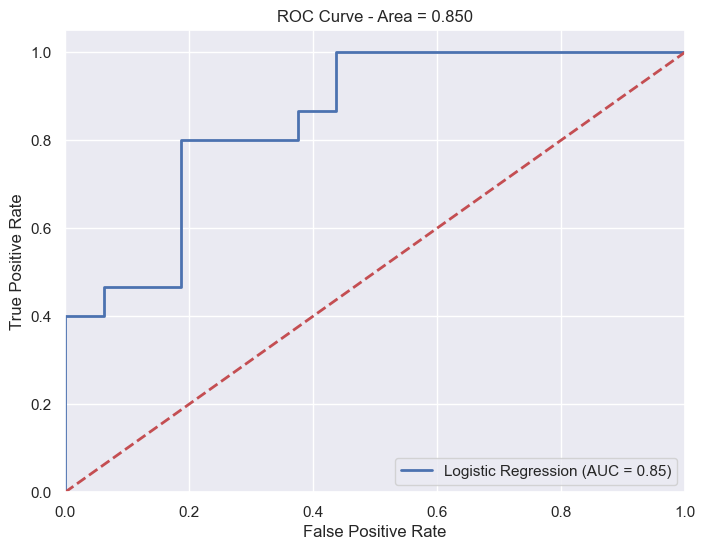

In [ ]:
logit_probs = res6.predict(logit_df[['peopl_sent', 'increase_new_cases']])

# Calculate ROC curve and AUC
logit_roc_auc = roc_auc_score(logit_df['trump_sent'], logit_probs)
fpr, tpr, thresholds = roc_curve(logit_df['trump_sent'], logit_probs)
auc_score = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % logit_roc_auc, linewidth=2)
plt.plot([0, 1], [0, 1], 'r--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve - Area = {:.3f}".format(auc_score))
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


AUC at 0.85 is a good result, it means that the model is able to distinguish between positive and negative sentiment with a good accuracy. We expected that since the accuracy is high.

# Causal Impact Analysis

In one of our analysis, we are interested in finding a causal relation between Trump's tweets and the number of visits to the page of Hydroxychloroquine on Wikipedia. During COVID-19 period Trump claimed that Hydroxychloroquine was a cure for COVID-19, this claim was not supported by scientific evidence. 

Initially we will do a preliminary graphical analysis looking at the number of visits to the page of Hydroxychloroquine on Wikipedia. We will plot the time series and draw a red line everytime Trump tweeted about Hydroxychloroquine.

After a the preliminary analysis, we will use  the [Causal Impact](https://google.github.io/CausalImpact/CausalImpact.html) library in Python to perform a test which can tell us if there is a causal relation between Trump's tweets and the number of visits to the page of Hydroxychloroquine.
To run this analysis we need to build a dataframe with the following columns:
- data index: the date of the observation of our time series.
- y: the number of visits to the the page of Hydroxychloroquine (test variable).
- x: the number of visits to the page of Baricitinib, a drug that was used to treat Covid-19 and that was not mentioned by Trump(control variable).

The Causality assumptions need to be verified:
- The x is not affected by the intervention (Trump's tweets) but they are correlated to y.
- The correlation between y and x should not be affected by the intervention.

We decided to take Baricitinib as a control because it is a drug used as anti-rheumatoid and that was not mentioned by Trump. We assume that the number of visits to the page of Baricitinib is not affected by Trump's tweets but it is correlated to the number of visits to the page of Hydroxychloroquine, since both drugs are used to treat rheumatoid arthritis.

Let's see the number of tweets where Hydroxychloroquine is mentioned:

In [ ]:
fake_news = ['Hydroxychloroquine', 'hydroxychloroquine']
analyze = data['text'].apply(lambda x: True if any(word in x for word in fake_news) else False)

# create a new column with the result of the analysis
new_col = analyze.reindex(data.index, fill_value=False)
data['Hydroxychloroquine']=new_col

print('Number of tweets talking about Hydroxychloroquine is: ', data['Hydroxychloroquine'].sum())

Number of tweets talking about Hydroxychloroquine is:  22


In [ ]:
# get the dates where trump spoke about Hydroxychloroquine
critical_data_hydro = data[data['Hydroxychloroquine'] == True]['date']
week_critical_data_hydro = (critical_data_hydro - pd.to_timedelta((critical_data_hydro.dt.dayofweek+1) % 7, unit='D')).unique()

We want to get from wikipedia and from Google Trends the number of pageviews for the article related to Hydroxychloroquine. We want to graphically inspect the variation of visits number over time and see if Trump's tweets had an impact on the number of visits.

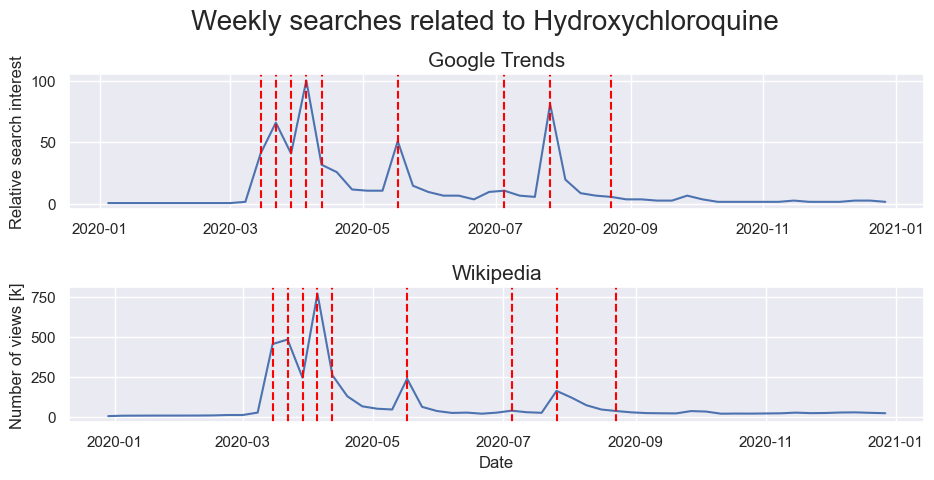

In [ ]:
pagename = 'Hydroxychloroquine'
filename = 'hydroxychloroquine'

weekly_wikipedia_hydro_df, daily_wikipedia_hydro_df = load_wikipedia_df(pagename, filename)
gtrends_hydro_df = load_gtrend_df(pagename, filename)

daily_wikipedia_hydro_df = daily_wikipedia_hydro_df.drop('Week', axis=1)
daily_wikipedia_hydro_df

fig, axis = plt.subplots(ncols=1, nrows=2, figsize=(10,5))
fig.tight_layout(pad=3.0)

fig.suptitle('Weekly searches related to {pagename}'.format(pagename=pagename), size=20)
fig.subplots_adjust(top=0.85)

axis[0].set_title('Google Trends', size=15)
axis[0].set_ylabel('Relative search interest')
axis[0].plot(gtrends_hydro_df['Views'])
[axis[0].axvline(x=critical_date, color='red', linestyle='--') for critical_date in week_critical_data_hydro]

axis[1].set_title('Wikipedia', size=15)
axis[1].set_ylabel('Number of views [k]')
axis[1].plot(weekly_wikipedia_hydro_df['Views']/10**3)
[axis[1].axvline(x=critical_date, color='red', linestyle='--') for critical_date in week_critical_data_hydro]
axis[1].set_xlabel('Date')

plt.show()

As we can see the Wikipedia and Google trend pageviews behave simarly, Google Trends, uses a relative scale from 0 to 100 while Wikipedia returns the absolute number of visits. We can see that the number of visits was almost zero until march 2020. The spikes in the graph appear almost at the same time with Trump's Tweet. We should further investigate if there is a causal relationship between Trump's tweets and the number of visits. 

To better visualize the impact of Tweets on wikipedia search we can plot a daily visualization instead of a weekly one

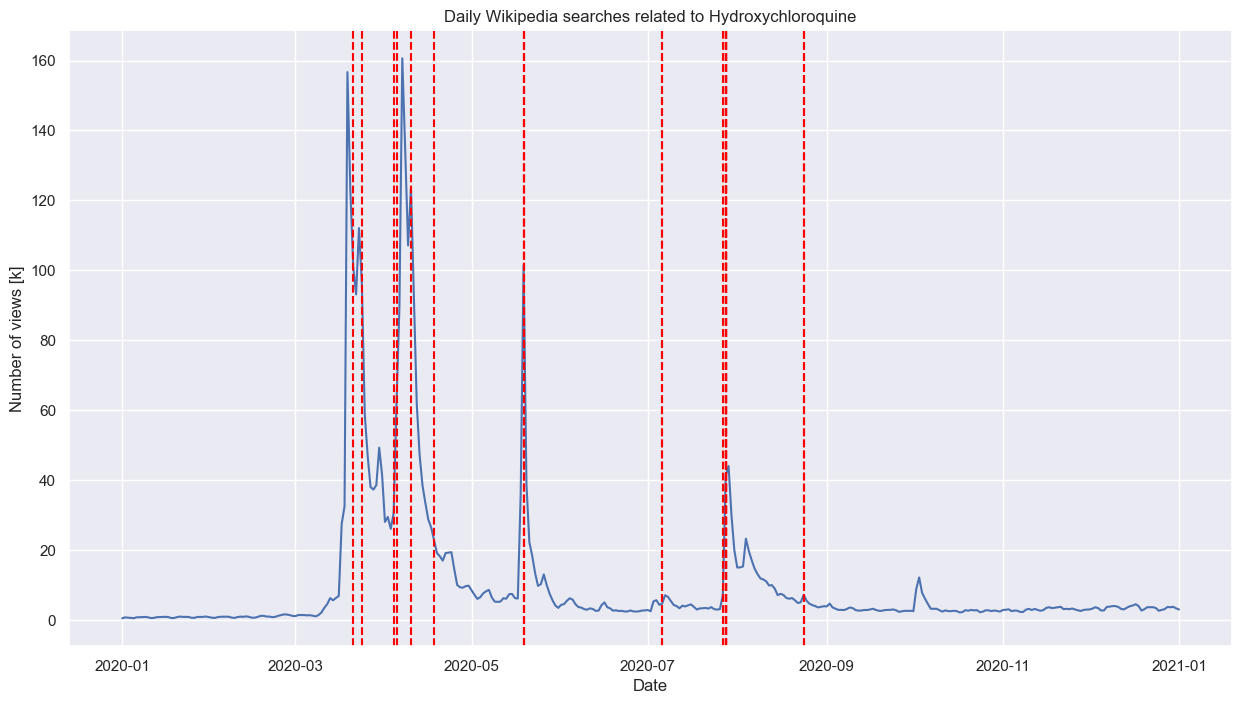

In [ ]:
plt.title('Daily Wikipedia searches related to {pagename}'.format(pagename=pagename, size=20), size=12)
plt.ylabel('Number of views [k]')
plt.plot(daily_wikipedia_hydro_df['Views']/10**3)
[plt.axvline(x=critical_date, color='red', linestyle='--') for critical_date in critical_data_hydro]
plt.xlabel('Date')
plt.show()

As we can see clearly from the graph above, Trump tweets about the topic generally draw attention on the Hydroxychloroquine topic on wikipedia (we plotted only wikipedia since GG Trends does not have daily granularity of the data as an option). Even though this behaviour is evident from the plot, the first spike in popularity on the topic happens before the first Tweet on the subject by Donald Trump. This will lead to a biased causal analysis using the bayesian approach. This bias becomes evident from the results below.

Let's follow the same procedure for Baricitinib:

In [ ]:
ci_hydro_df = daily_wikipedia_hydro_df.copy()
ci_hydro_df = ci_hydro_df.rename(columns = {'Views' :'y'})
stop_date_hydro = week_critical_data_hydro[0]
print('First time Trump talked about Hydroxychloroquine: ', stop_date_hydro + pd.Timedelta(days=1))

pagename = 'Baricitinib'
filename = 'baricitinib'

weekly_wikipedia_baricitinib_df, daily_wikipedia_baricitinib_df = load_wikipedia_df(pagename, filename)
gtrends_baricitinib_df = load_gtrend_df(pagename, filename)

daily_wikipedia_baricitinib_df = daily_wikipedia_baricitinib_df.drop('Week', axis=1)


ci_hydro_df['x'] = daily_wikipedia_baricitinib_df

First time Trump talked about Hydroxychloroquine:  2020-03-16 00:00:00


To perform the test check if the hypothesis for causal impact analysis are satisfied:

In [ ]:
ci_hydro_df[:stop_date_hydro- pd.Timedelta(days=1)].corr()

,y,x
y,1.000000,0.595665
x,0.595665,1.000000


In [ ]:
ci_hydro_df[stop_date_hydro:week_critical_data_hydro[-1]].corr()

,y,x
y,1.000000,0.176224
x,0.176224,1.000000


The correlation between y and x should not be affected by the intervention, we see that is not the case, however. To relax this assumption we will therefore include [dynamic time-varying regression coefficients](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/41854.pdf), which account for time-varying relationships.

Still, given the fairly week correlation between the response and the control time series, our results of our analysis should be interpreted with caution.

In [ ]:
critical_data_hydro = pd.to_datetime(critical_data_hydro)

In [ ]:
pre_period = [ci_hydro_df.index[0], critical_data_hydro.iloc[0]- pd.Timedelta(days=1)]
post_period = [critical_data_hydro.iloc[1], critical_data_hydro.iloc[-1]]
print(pre_period, post_period)

[Timestamp('2020-01-01 00:00:00'), Timestamp('2020-03-20 00:00:00')] [Timestamp('2020-03-24 00:00:00'), Timestamp('2020-08-24 00:00:00')]


Now we can run the causal impact analysis:

c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: standardize, nseasons. After release 0.14, this will raise.
  warnings.warn(
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


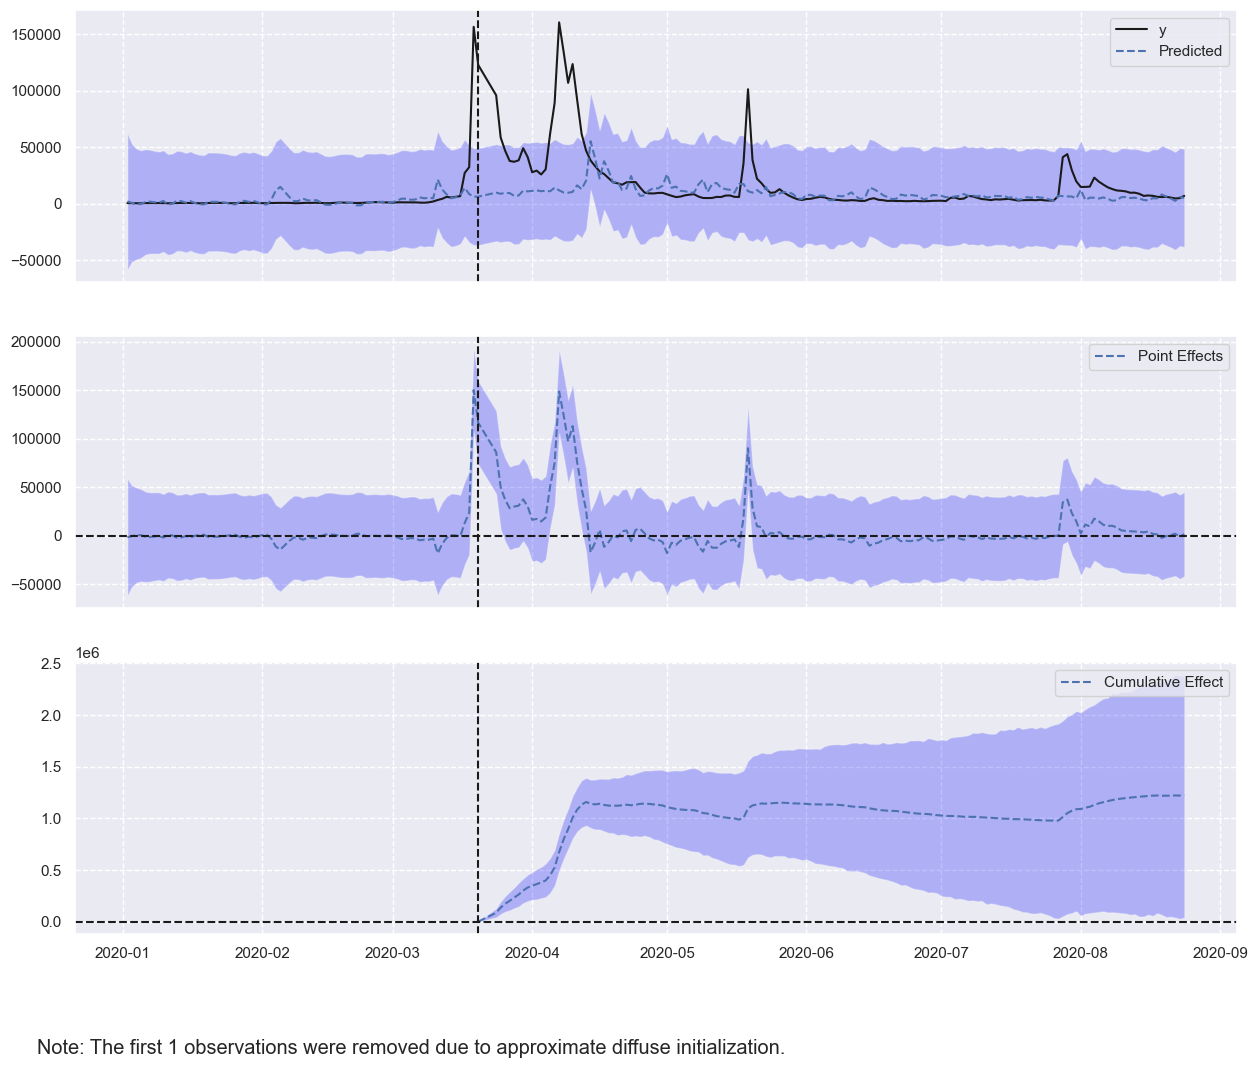

In [ ]:
impact = CausalImpact(data = ci_hydro_df, pre_period=pre_period, post_period=post_period)
impact.plot()

In [ ]:
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    17862.1            2750764.0
Prediction (s.d.)         9923.79 (3878.79)  1528263.87 (597334.3)
95% CI                    [2401.03, 17605.62][369758.09, 2711265.51]

Absolute effect (s.d.)    7938.31 (3878.79)  1222500.13 (597334.3)
95% CI                    [256.48, 15461.08] [39498.49, 2381005.91]

Relative effect (s.d.)    79.99% (39.09%)    79.99% (39.09%)
95% CI                    [2.58%, 155.8%]    [2.58%, 155.8%]

Posterior tail-area probability p: 0.02
Posterior prob. of a causal effect: 97.6%

For more details run the command: print(impact.summary('report'))


Looking at the graph it seems that immediately after the intervention the number of visits to the page of Hydroxychloroquine increased, however the confidence intervals are very wide and we cannot conclude that there is a causal relation between Trump's tweets and the number of visits to the page of Hydroxychloroquine. This graph could suggest us that the analysis we want to undertake could be unfruitful. During Milestone 3 we could try to find a better control variable and see if we can find a causal relation between Trump's tweets and the number of visits to the page of Hydroxychloroquine, or enlarge the analysis to other fake news.

As hydroxychloroquine  was not the only fake news spread by Trump, we repeated the same preliminary analysis and visualizations for other fake news, to get a better idea of how well our observations for hydroxychloroquine generalize to other topics.

### 1)  Swine Flu

Trump was tweeting a lot about Swine Flu to attack the democrats, one can study if he was resurging a trend:

Number of tweets talking about Swine Flu is:  26


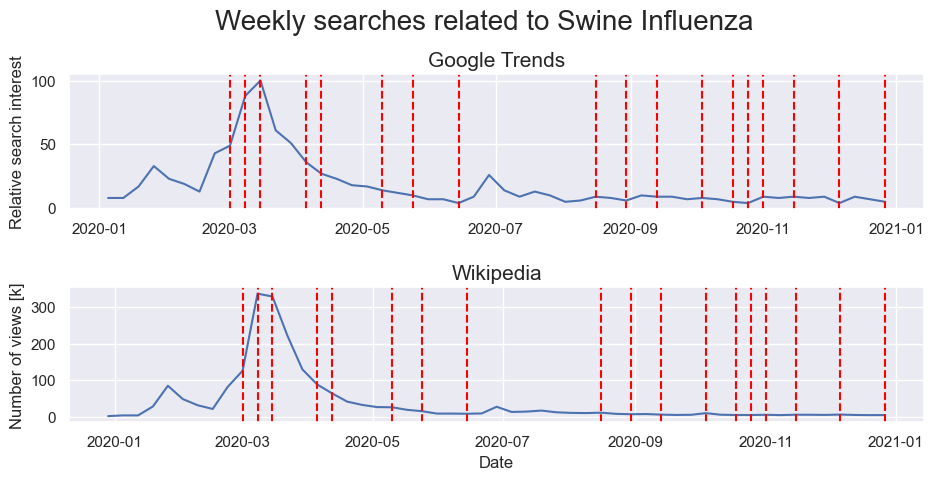

In [ ]:
fake_news_swineflu = ['Swine', 'swine', 'H1N1', 'h1n1']
analyze_swineflu = data['text'].apply(lambda x: True if any(word in x for word in fake_news_swineflu) else False)

# create a new column with the result of the analysis
new_col = analyze_swineflu.reindex(data.index, fill_value=False)
data['Swineflu'] = new_col
print('Number of tweets talking about Swine Flu is: ', data['Swineflu'].sum())

# get the dates where trump spoke
critical_data = data[data['Swineflu'] == True]['date']
week_critical_data = (critical_data - pd.to_timedelta((critical_data.dt.dayofweek+1) % 7, unit='D')).unique()
            
pagename = 'Swine Influenza'
filename = 'swineflu'

weekly_wikipedia_df, _ = load_wikipedia_df(pagename, filename)
gtrends_df = load_gtrend_df(pagename, filename)

fig, axis = plt.subplots(ncols=1, nrows=2, figsize=(10,5))
fig.tight_layout(pad=3.0)

fig.suptitle('Weekly searches related to {pagename}'.format(pagename=pagename), size=20)
fig.subplots_adjust(top=0.85)

axis[0].set_title('Google Trends', size=15)
axis[0].set_ylabel('Relative search interest')
axis[0].plot(gtrends_df['Views'])
[axis[0].axvline(x=critical_date, color='red', linestyle='--') for critical_date in week_critical_data]

axis[1].set_title('Wikipedia', size=15)
axis[1].set_ylabel('Number of views [k]')
axis[1].plot(weekly_wikipedia_df['Views']/10**3)
[axis[1].axvline(x=critical_date, color='red', linestyle='--') for critical_date in week_critical_data]
axis[1].set_xlabel('Date')

plt.show()

From the plot, it seems that peaks in popularity tend to start before Trump's tweets (especially the first two), but some of Trump's tweets might still have had some effect. His first tweet seemed to have increased the slope of the main popularity peak, and his tweets in mid-june 2020 might have cause the subsequent peak in interest (a smaller one, but Trump's tweet clearly precedes it this time).

### 2)  China Laboratory-Leak Virus

Trump was not tweeting directly about the fact that covid escaped from a lab, however, he tweeted a lot about the "China Virus", did this feed the trend?

Number of tweets talking about COVID-19 lab leak theory is:  44


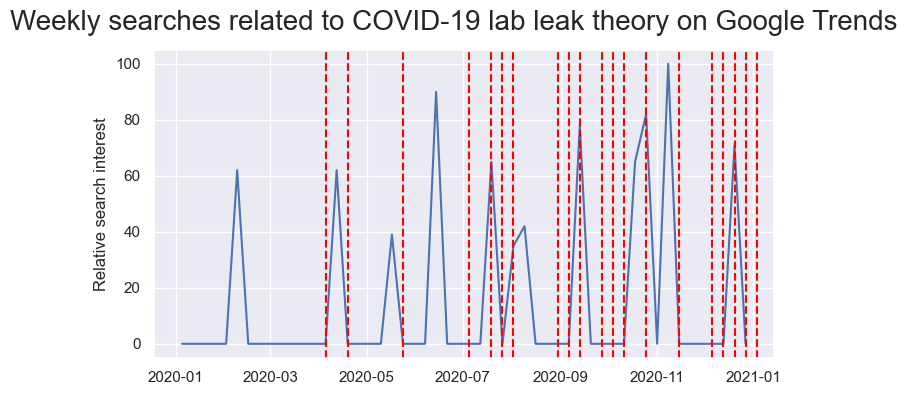

In [ ]:
fake_news_leaktheory = ['China virus', 'china virus', 'chinavirus', 'Chinavirus', 'China Virus']
analyze_leaktheory = data['text'].apply(lambda x: True if any(word in x for word in fake_news_leaktheory) else False)

# create a new column with the result of the analysis
new_col = analyze_leaktheory.reindex(data.index, fill_value=False)
data['Leaktheory'] = new_col
print('Number of tweets talking about COVID-19 lab leak theory is: ', data['Leaktheory'].sum())

# get the dates where trump spoke
critical_data = data[data['Leaktheory'] == True]['date']
week_critical_data = (critical_data - pd.to_timedelta((critical_data.dt.dayofweek+1) % 7, unit='D')).unique()
            
pagename = 'COVID-19 lab leak theory'
filename = 'leaktheory'

weekly_wikipedia_df, _ = load_wikipedia_df(pagename, filename)
gtrends_df = load_gtrend_df(pagename, filename)

plt.figure(figsize=(8, 4)) 

plt.suptitle('Weekly searches related to {pagename} on Google Trends'.format(pagename=pagename), size=20)

plt.ylabel('Relative search interest')
plt.plot(gtrends_df['Views'])
[plt.axvline(x=critical_date, color='red', linestyle='--') for critical_date in week_critical_data]

plt.show()

For the 'Lab Leak Theory' the graph is much more hectic and it's hard to conclude on any causal effect of Trump's tweets on online trends.

### Granger causality test

Our causal impact analysis has shown that Trump's tweets and online trends were often related, especially for hydroxychloroquine for instance. It was, however, sometimes difficut to establish whether Trump's tweet preceded the trends. To investigate this, we chose to conduct [Granger causality]() tests. "The Granger causality test is a statistical hypothesis test for determining whether one time series is useful in forecasting another".

The [null hypothesis](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.grangercausalitytests.html) is that "the the time series in the second column, x2, does NOT Granger cause the time series in the first column, x1".

In [ ]:
# Put the tweets in a format compatible with Granger causality analysis (i.e. time series)
tweets_hydro_timeseries_df = pd.DataFrame(index=gtrends_hydro_df['Views'].index, columns=['Date'])

for date in week_critical_data_hydro:
    tweets_hydro_timeseries_df[date] = (tweets_hydro_timeseries_df.index == date).astype(int)

tweets_hydro_timeseries_df['Date'].fillna(0, inplace=True)
tweets_hydro_timeseries_df['Tweet'] = tweets_hydro_timeseries_df.iloc[:, 1:].sum(axis=1)

# Combine gtrends and tweets
gtrends_tweets_hydro_df = gtrends_hydro_df.copy()
gtrends_tweets_hydro_df['Tweets'] = tweets_hydro_timeseries_df['Tweet']

# Combine wiki and tweets
wiki_tweets_hydro_df = weekly_wikipedia_hydro_df.copy()
wiki_tweets_hydro_df['Tweets'] = tweets_hydro_timeseries_df['Tweet']
wiki_tweets_hydro_df['Tweets'].fillna(0, inplace=True)

Let's start with a Granger test checking whether Google Trends views caused tweets or vice versa.

In [ ]:
# Granger test between GTrends views and tweets
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

print("DO VIEWS CAUSE TWEETS?")
grangercausalitytests(gtrends_tweets_hydro_df, 2)

print('\n --------------------------------')
print("\n DO TWEETS CAUSE VIEWS?")
tweets_cause_views_gtrends = grangercausalitytests(gtrends_tweets_hydro_df[['Tweets', 'Views']], 2)

DO VIEWS CAUSE TWEETS?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4121  , p=0.1270  , df_denom=48, df_num=1
ssr based chi2 test:   chi2=2.5628  , p=0.1094  , df=1
likelihood ratio test: chi2=2.5005  , p=0.1138  , df=1
parameter F test:         F=2.4121  , p=0.1270  , df_denom=48, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9774  , p=0.3841  , df_denom=45, df_num=2
ssr based chi2 test:   chi2=2.1720  , p=0.3376  , df=2
likelihood ratio test: chi2=2.1262  , p=0.3454  , df=2
parameter F test:         F=0.9774  , p=0.3841  , df_denom=45, df_num=2

 --------------------------------

 DO TWEETS CAUSE VIEWS?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9602  , p=0.0523  , df_denom=48, df_num=1
ssr based chi2 test:   chi2=4.2077  , p=0.0402  , df=1
likelihood ratio test: chi2=4.0431  , p=0.0444  , df=1
parameter F test:         F=3.9602  , p=0.0523  , df_denom=48, df_num=1

Granger Causalit

The p-values for Views causing Tweets is above 0.05 by a margin, so no signficance there.
The p-values for Tweets causing Views are around 0.05, however: so the causality is just barely significant - Trump might indeed have an impact on Tweets.

Let's redo the test with Wikipedia pageviews.

In [ ]:
# Granger test between Wikipedia pageviews and tweets
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

print("DO VIEWS CAUSE TWEETS?")
grangercausalitytests(wiki_tweets_hydro_df, 2)

print('\n \n --------------------------------')
print("\n \n DO TWEETS CAUSE VIEWS?")
tweets_cause_views_wiki = grangercausalitytests(wiki_tweets_hydro_df[['Tweets', 'Views']], 2)

DO VIEWS CAUSE TWEETS?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1650  , p=0.1476  , df_denom=49, df_num=1
ssr based chi2 test:   chi2=2.2976  , p=0.1296  , df=1
likelihood ratio test: chi2=2.2483  , p=0.1338  , df=1
parameter F test:         F=2.1650  , p=0.1476  , df_denom=49, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7117  , p=0.4961  , df_denom=46, df_num=2
ssr based chi2 test:   chi2=1.5782  , p=0.4543  , df=2
likelihood ratio test: chi2=1.5542  , p=0.4597  , df=2
parameter F test:         F=0.7117  , p=0.4961  , df_denom=46, df_num=2

 
 --------------------------------

 
 DO TWEETS CAUSE VIEWS?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.6313 , p=0.0013  , df_denom=49, df_num=1
ssr based chi2 test:   chi2=12.3434 , p=0.0004  , df=1
likelihood ratio test: chi2=11.0755 , p=0.0009  , df=1
parameter F test:         F=11.6313 , p=0.0013  , df_denom=49, df_num=1

Granger Caus

The results are much more marked now: the p-values for Tweets causing Views are well below the threshold of 0.05 - Trump's tweets seemed to have an impact on Wikipedia pageviews.

___
## Part 2: Causal Impact Analyis of Alternative Hypotheses
We studied how Trump's tweet can affect the public debate. This part proposes to perform a causal impact analysis on alternative hypothesis. To do so, we'll study the effect of discrete event on our topics (mobility changepoints and public events in the US) and use the total trafic on Wikipedia as a time serie baseline.

The following part is reusing code and helper functions from the work [Sudden Attention Shifts on Wikipedia During the COVID-19 Crisis](https://github.com/epfl-dlab/wiki_pageviews_covid)

In [ ]:
params = {
    "axes.titlesize" : 14,
    'axes.labelsize': 12,
    'font.size': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'text.usetex': False
}

mpl.rcParams.update(params)

In [ ]:
interventions = load_interventions("wiki_pageviews_covid/data/interventions.csv")
topics_df, topics = load_topics('wiki_pageviews_covid/data/topics_linked.csv.xz')
agg = load_aggregated("wiki_pageviews_covid/data/aggregated_timeseries.json.gz")
codes_order = ["sr", "it", "fr", "en", "nl", "ko", "de", "fi", "ja", "no", "sv", "da"]
dfs_pca_shift = load_pca(codes_order, pca_folder="wiki_pageviews_covid/data/pca/")

The following plot shows the evolution of pageview on wikipedia, and the amount of them related to covid. We'll superimpose the trends on Hydroxichloroquine to spot a potential correlation. Note that since the covid fighting strategies differed from a state to another, we enriched the dataset with the date of first school closure, or first lockdown in the US.

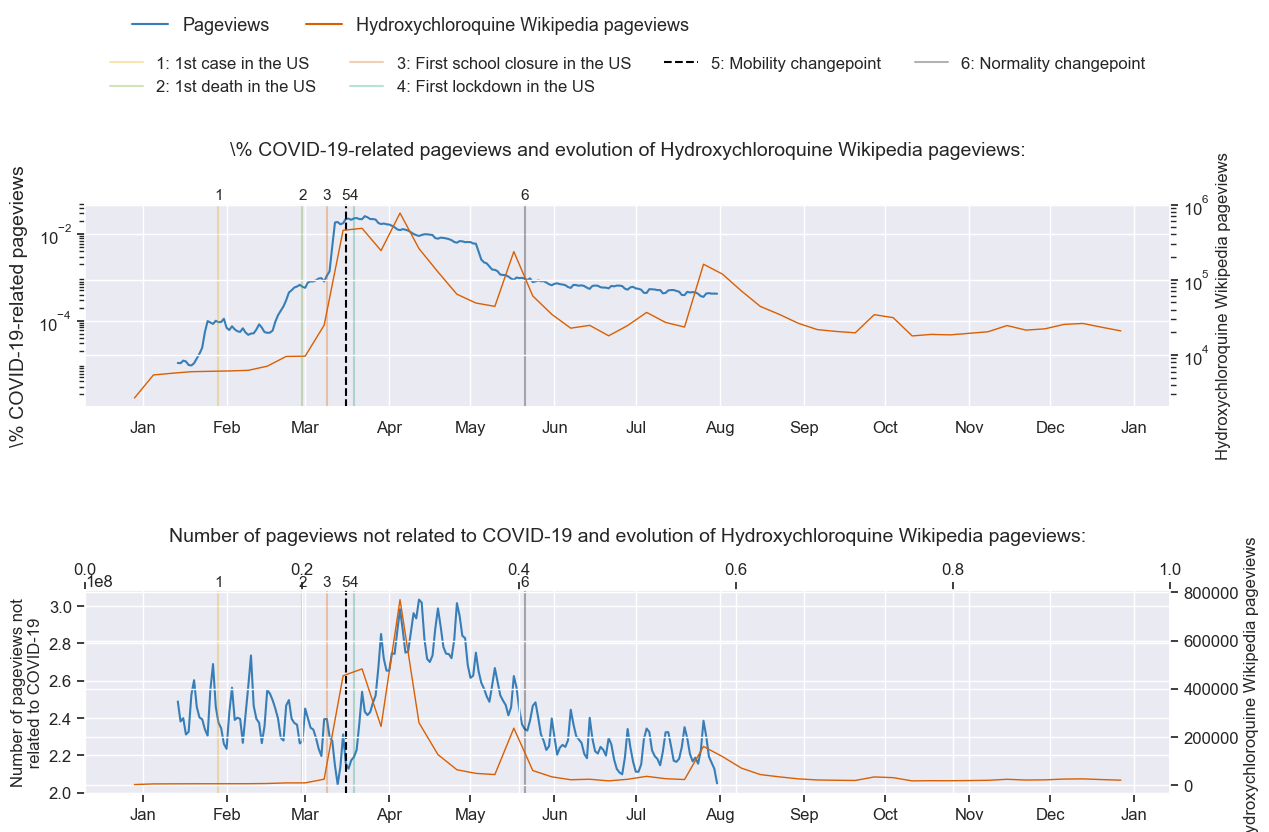

In [ ]:
idx =3
fig, axs = plt.subplots(2, 1,
                       figsize=(14, 10),
                       sharex=False,
                       gridspec_kw={"hspace": 0.9, "wspace": 0.15, "top": 0.7})
# COVID-RELATED PAGEVIEWS
ax = axs[0]
code = codes_order[idx]
ax.set_ylabel(helper_langs[code], rotation=0, ha="right", va="center", fontsize=14)
start, end = plot_dates(ax, 20200114, 20200731, 
                        agg[code]["sum"].index,
                        (agg[code]["covid"]["sum"].values + agg[code + ".m"]["covid"]["sum"].values +1) 
                        / (agg[code]["sum"].values + agg[code+".m"]["sum"].values),  sci=False, color="#377eb8")

plot_intervention(ax, interventions, code, "all", interventions_helper, int_ls, int_c)


ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

ax.set_ylabel("\% COVID-19-related pageviews", rotation=90,labelpad=14.0)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('right')
ax.set_yscale("log")
ax.set_ylim([10**(-6), 5* 10**(-2)])
ax.set_yticks([10**(-4), 10**(-2)])

ax02 = ax.twinx() 
ax02.set_ylabel('Hydroxychloroquine Wikipedia pageviews') 
ax02.plot(weekly_wikipedia_hydro_df['Views'], color='#d95f02', linewidth=1)
ax02.set_yscale('log')
ax02.tick_params(axis ='y') 

# NON COVID-RELATED PAGEVIEWS
ax = axs[1]

ax_twin = ax.twiny()

start, end = plot_dates(ax, 20200114, 20200731, 
                    agg[code]["sum"].index, agg[code]["sum"].values + agg[code + ".m"]["sum"].values -
                    agg[code]["covid"]["sum"].values - agg[code +".m"]["covid"]["sum"].values, 
                        color="#377eb8", sci=False)

plot_intervention(ax, interventions, code, "all", interventions_helper, int_ls, int_c)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

for ax_t in [ax, ax_twin]:
    ax_t.spines['left'].set_visible(False)
    ax_t.spines['top'].set_visible(False)
    ax_t.yaxis.set_ticks_position('right')

ax.set_ylabel("Number of pageviews not\n related to COVID-19 ")

ax12 = ax.twinx() 
ax12.set_ylabel(' Hydroxychloroquine Wikipedia pageviews') 
ax12.plot(weekly_wikipedia_hydro_df['Views'], color='#d95f02', linewidth=1)
ax12.tick_params(axis ='y') 

#General labels:
axs[0].set_title("\% COVID-19-related pageviews and evolution of Hydroxychloroquine Wikipedia pageviews:",pad=35)
axs[1].set_title("Number of pageviews not related to COVID-19 and evolution of Hydroxychloroquine Wikipedia pageviews:",pad=35)

lines = [
    Line2D([0], [0], color="#377eb8", lw=1.5, ls="-"),
    Line2D([0], [0], color='#d95f02', lw=1.5, ls="-"),
    Line2D([0], [0], color="black", lw=1.5, ls=":")
]

axs[0].legend(
    handles=lines,
    labels=["Pageviews","Hydroxychloroquine Wikipedia pageviews"],
    loc='upper center', bbox_to_anchor=(0.3, 2),
    ncol=3, fancybox=False, shadow=False,
    frameon=False, edgecolor=None, fontsize=13
)
lines_interv = [Line2D([0], [0], color=int_c[x], ls=int_ls[x], alpha=0.3 if x != "Mobility" else 1.) 
                for x, _ in interventions_helper.items()]

axs[1].legend(
    handles= lines_interv,
    labels=["{}: {}".format(v, 
                            k.replace("Mobility", "Mobility changepoint")\
                            .replace("Normalcy", "Normality changepoint"))
            for k, v in interventions_helper.items()],
    loc='upper center', bbox_to_anchor=(.5,3.7),
    ncol=4, fancybox=False, shadow=False,
    frameon=False, edgecolor=None, fontsize=12
)

### Causal Impact

To further investigate the observations made above, let's start by conducting a Causal Impact study, similar to what we did in Part 1.B) of an event that visually seems to have influenced Wikipedia pageviews for hydroxychloroquine: the mobility changepoint.

The start of the postperiod is set to the mobility changepoints in the US.

In [ ]:
date_restriction = pd.to_datetime('2020-03-16')
date_restriction

Timestamp('2020-03-16 00:00:00')

And the end of the postperiod is set to the normality changepoint, which we thought marked a post-postperiod in a sense, which we wanted to avoid.

In [ ]:
date_normality = pd.to_datetime('2020-05-21')
date_normality

Timestamp('2020-05-21 00:00:00')

In [ ]:
ci_hydro_df.head()

,y,x
Date,,
2020-01-01,547,40
2020-01-02,793,84
2020-01-03,717,71
2020-01-04,616,43
2020-01-05,563,40


Again, let's assess whether the assumptions of correlatedness hold for the pre- and post-period.

In [ ]:
ci_hydro_df[:date_restriction].corr()

,y,x
y,1.000000,0.578258
x,0.578258,1.000000


In [ ]:
ci_hydro_df[date_restriction:date_normality].corr()

,y,x
y,1.000000,-0.208032
x,-0.208032,1.000000


Similarly as in our previous causal analysis study, the correlation is not particularly strong, and above all it is time-varying, which is why we will be using dynamic time-varying regression coefficients again.

In [ ]:
pre_period = [ci_hydro_df.index[0], date_restriction]
post_period = [date_restriction + timedelta(days=1), date_normality]
print(pre_period, post_period)

[Timestamp('2020-01-01 00:00:00'), Timestamp('2020-03-16 00:00:00')] [Timestamp('2020-03-17 00:00:00'), Timestamp('2020-05-21 00:00:00')]


c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: standardize, model_args, nseasons. After release 0.14, this will raise.
  warnings.warn(
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


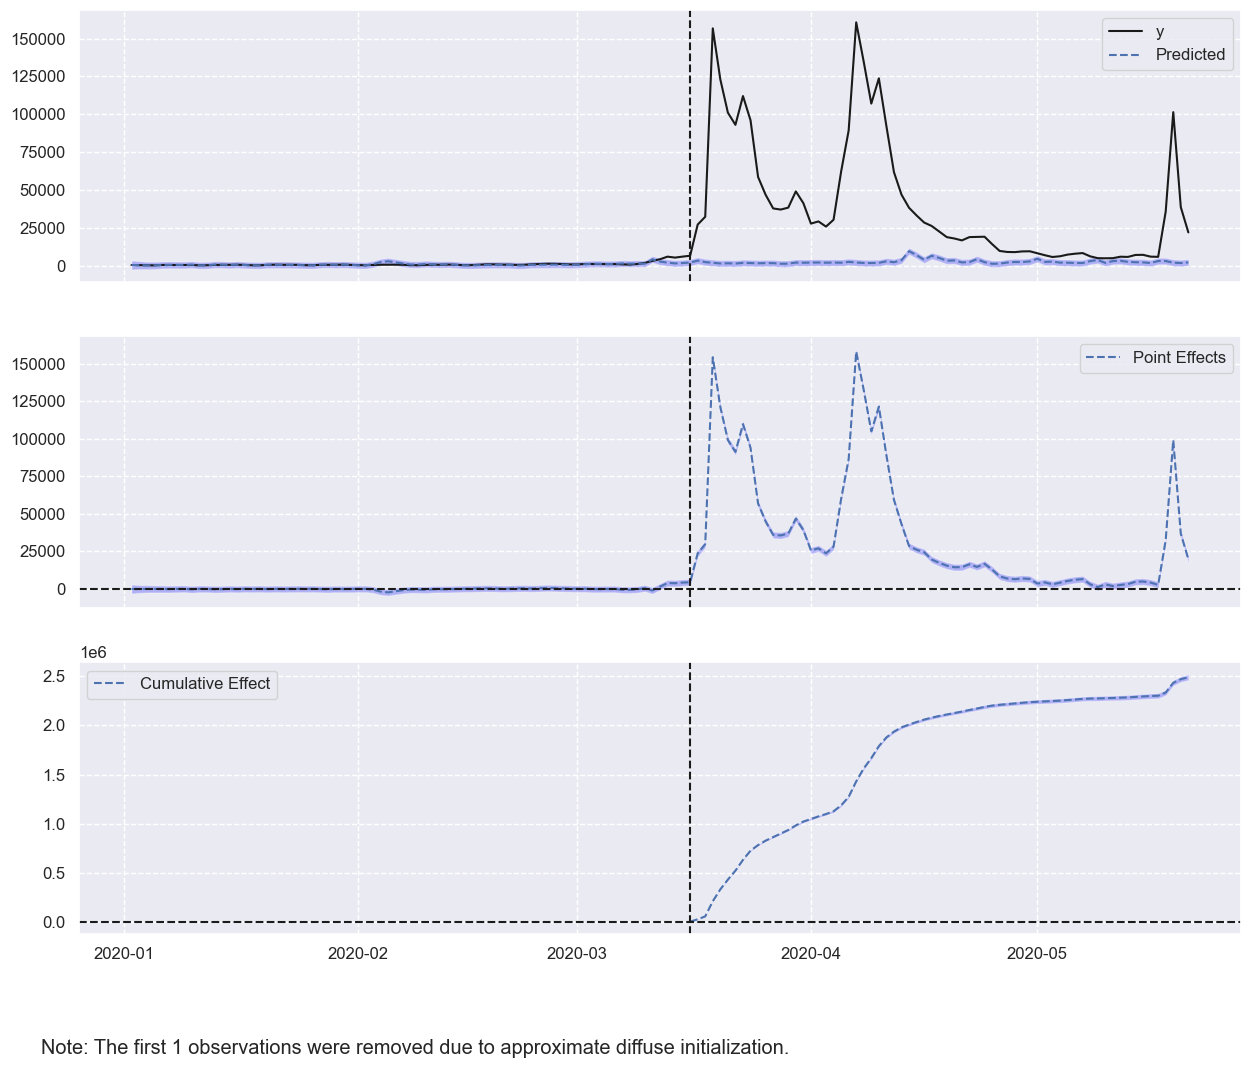

In [ ]:
impact = CausalImpact(data=ci_hydro_df, pre_period=pre_period, post_period=post_period, model_args={'dynamic_regression': True})
impact.plot()

The plot clearly shows a strong causal impact of the mobility changepoints on pageviews: the changepoint precedes the big peaks in hydroxychloroquine views which were not apparent in searches for searches of the control timeseries. The confidenc intervals are furthermore very tight.

We should however be cautious when interpreting these results, as the correlation between the control and response time series is not so strong.

### Granger Causality

Finally, let's conduct a Granger causality test to see whether interventions (e.g. first Covid case) in the US could have caused trends in hydroxychloroquine views on Google.

In [ ]:
# Put the interventions in a format compatible with Granger causality analysis (i.e. time series)
interventions_us_dates = pd.Series(interventions['en'].values())
interventions_us_dates_weekly = (interventions_us_dates - pd.to_timedelta((interventions_us_dates.dt.dayofweek+1) % 7, unit='D')).unique()

interventions_hydro_timeseries_df = pd.DataFrame(index=gtrends_hydro_df['Views'].index, columns=['Date'])

for date in interventions_us_dates_weekly:
    interventions_hydro_timeseries_df[date] = (interventions_hydro_timeseries_df.index == date).astype(int)

interventions_hydro_timeseries_df['Date'].fillna(0, inplace=True)
interventions_hydro_timeseries_df['Interventions'] = interventions_hydro_timeseries_df.iloc[:, 1:].sum(axis=1)

# Combine gtrends and interventions
gtrends_interventions_hydro_df = gtrends_hydro_df.copy()
gtrends_interventions_hydro_df['Interventions'] = interventions_hydro_timeseries_df['Interventions']

gtrends_interventions_hydro_df.head()

,Views,Interventions
Date,,
2020-01-05,1,0
2020-01-12,1,0
2020-01-19,1,0
2020-01-26,1,1
2020-02-02,1,0


In [ ]:
# Granger test between GTrends views and tweets
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

print("DO INTERVENTIONS CAUSE VIEWS?")
interventions_cause_views = grangercausalitytests(gtrends_interventions_hydro_df[['Interventions', 'Views']], )

DO INTERVENTIONS CAUSE VIEWS?


TypeError: grangercausalitytests() missing 1 required positional argument: 'maxlag'

p-values are well above 0.05: the null hypothesis is sufficient to explain the timeseries. That is in contrast with the results we obtained with Trump's tweets, which did seem to cause shifts in online trends.

# Conclusion

TODO